## Anisotropic heterogeneous wave equation with mixed boundary conditions

This tutorial aims at illustrating the use of the Partitioned Finite Element Method (PFEM) (Cardoso-Ribeiro et al, 2018) to discretize a port-Hamiltonian system (pHs) related to the simulation of the two-dimensional anisotropic heterogeneous wave equation with boundary damping and mixed boundary conditions. We specifically learn how to define and solve this problem inside Scrimp.  

We first define the continuous problem. Then we tackle the semi-discretization in space of the port-Hamiltonian system through the PFEM methodology. This discretization leads to a pHDAE formulation. After time discretization, we perform a numerical simulation to obtain an approximation of the space-time solution. Finally a simple postprocessing is performed. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import Scrimp
from math import pi

/usr/local/lib/python3.8/dist-packages/Assimulo-trunk-py3.8-linux-x86_64.egg/assimulo/solvers/odepack.py:710: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order
Could not find GLIMDA.


## Problem statement


We consider the two-dimensional heterogeneous anisotropic wave equation with impedance boundary condition defined for all $t\ge 0$ as

$$
\begin{array}{ll} 
    \rho(\boldsymbol x)\,\displaystyle \frac{\partial^2}{\partial t^2} w(t,\boldsymbol x) &=& \text{div}\Big(\overline{\overline T}(\boldsymbol x)\cdot\textbf{grad} \ w(t,\boldsymbol x)\Big), \quad \boldsymbol x \in \Omega, \\
    Z(\boldsymbol x)~(\overline{\overline T}(\boldsymbol x)\cdot\textbf{grad} \ w(t,\boldsymbol x)) \cdot {\bf{n}} + 
    {\partial_t} w(t,\boldsymbol x) & = & 0, \quad \boldsymbol x \in \partial \Omega, \\ 
    w(0, \boldsymbol x) & = & w_0(x), \quad \boldsymbol x \in \Omega, t=0 \\
    {\partial_t} w(0,\boldsymbol x) & = & w_1(x), \quad \boldsymbol x \in \Omega, t=0, \\
\end{array}
$$

with $\Omega \subset \mathbb{R}^2$ an open bounded spatial domain with Lipschitz-continuous boundary $\delta \Omega$. 
In this tutorial we consider a rectangular shaped domain for $\Omega$. $w(t,\boldsymbol x)$ denotes the deflection from the equilibrium position at point $\boldsymbol x \in \Omega $ and time $t$. $\rho \in L^{\infty}(\Omega)$ (positive and bounded from below) denotes the mass density, $\overline{\overline T} \in L^{\infty}(\Omega)^{2\times 2}$ (symmetric and coercive) the Young's elasticity modulus, and $Z(\boldsymbol x)$ is the positive impedance function defined on $\partial \Omega$. Mixed boundary conditions are considered in this example. In the following the subsets $\Gamma_N$ and $\Gamma_D$ represent the subsets of the boundary where Neumann and Dirichlet conditions hold respectively.


## Port-Hamiltonian formulation 

We introduce the energy variables (strain and linear momentum, respectively) as

$$
\boldsymbol \alpha_q = \textbf{grad} \ w(t,\boldsymbol x), \quad 
\alpha_p = \rho~{\partial_t} w(t,\boldsymbol x),
$$ 

the Hamiltonian (total mechanical energy) as

$$
\mathcal{H} = \frac{1}{2} \int_{\Omega} {\boldsymbol \alpha_q}^T . \overline{\overline T}(\boldsymbol x) . \boldsymbol \alpha_q  + \alpha_p \frac{1}{\rho} \alpha_p~dx
$$

and the co-energy variables (stress and velocity, respectively) as

$$
e_q = \partial_{\boldsymbol \alpha_q} \mathcal{H} = \overline{\overline T}(\boldsymbol x) . \boldsymbol \alpha_q, \quad 
e_p = \partial_{\alpha_p} \mathcal{H} = \frac{1}{\rho} \alpha_p,
$$

with $\partial_{\alpha_p}$ denoting the variational derivative with respect to the variable $\alpha_p$. The infinite-dimensional port-Hamiltonian system can then be written as

\begin{eqnarray*}
\partial_t \left \lbrack 
\begin{array}{c}
\boldsymbol \alpha_q \\
\alpha_p 
\end{array}
\right \rbrack 
&=& 
\left \lbrack 
\begin{array}{cc}
0  & \textbf{grad} \\
div & 0 \\
\end{array}
\right \rbrack
\left \lbrack
\begin{array}{c}
e_q \\
e_p 
\end{array}
\right \rbrack, \quad u_{\partial} = e_{p_{|\delta \Omega}} \quad y_{\partial} = e_q . n_{|\delta \Omega}.
\end{eqnarray*}

With the output-feedback law $u_{\partial} = -Z y_{\partial}$, we deduce the relation

$$
Z e_q.n_{|\delta \Omega} + e_{p_{|\delta \Omega}} = 0. 
$$

The existence and uniqueness of the solution of the port-Hamiltonian system is ensured
provided that ${\boldsymbol \alpha_q} \in \overline{\overline T}^{~-1} H^{div}(\Omega)$ and $
\alpha_p \in \rho H^1(\Omega)$ where

$$
\overline{\overline T}^{~-1} H^{div}(\Omega) = \left \lbrace \boldsymbol{v}_q \in L^2(\Omega), div(\overline{\overline T}^{~-1} v_q) \in L^2(\Omega) \right \rbrace,
\rho H^1(\Omega) = \left \lbrace v_p \in L^2(\Omega), {\boldsymbol{grad}}(\rho v_p) \in L^2(\Omega) \right \rbrace.
$$

## Setup

We initialize here the Python object related to the Wave_2D class of Scrimp. This object will be used throughout this 
tutorial. 

In [2]:
W = Scrimp.Wave_2D()

### Constants

We define the constants related to the definition of the rectangular domain $\Omega$. The coordinates of the left bottom ($x_0, y_0$) and the right top ($x_L, y_L$) corners of the rectangle are required. 

In [3]:
x0, xL, y0, yL = 0., 2., 0., 1.

We then define the time interval related to the time discretization. $t_i, t_f$ denote the initial and final time instants respectively. 

In [4]:
ti, tf  = 0., 10.

We specify that we choose the external library "Assimulo" to be used later for the time integration of the differential algebraic equation and provide the value of the time step. This should be considered as a reference value since adaptative methods in time can be used later. 

In [5]:
dt           = 1.e-3
dae_library  = 'DAE:Assimulo'

### FEniCS expressions definition

For the finite element discretization of the spatial port-Hamiltonian formulation, the FEniCS library is used in the Wave_2D class of Scrimp. Hence to properly use FEniCS expression definition, we provide the definition of the different variables in C++ code given in strings. We first specify the mass density as a function depending on the space coordinates. Hence in this expression, x[0] corresponds to the first spatial variable and x[1] to the second one, respectively.

In [6]:
Rho    = 'x[0]*x[0] * (2.-x[0])+ 1'

We specify the Young's elasticity modulus tensor. Three components are only required due to the symmetry property of this tensor. 

In [7]:
T11    = 'x[0]*x[0]+1'
T12    = 'x[1]'
T22    = 'x[0]+2'

We finally specify the impedance function $Z$ defined on the boundary of the domain. Here a constant value is used on $\partial \Omega$. We also specify the viscous damping function (eps) and the components of the viscoelastic tensor. 

In [8]:
Z   = '0.1'
eps = ' 25 * x[0] * (xL-x[0]) * x[1] * (yL-x[1])'
k11 = '1' 
k12 = '0' 
k22 = '1' 

We specify the initial conditions of the problem related to the deflection and to the energy variables.

In [9]:
W.Set_Rectangular_Domain(x0, xL, y0, yL)
W.Set_Initial_Data(Aq_0_1='0', Aq_0_2='0', Ap_0='0', W_0='0');

We impose the boundary control function ($w_1$) that controls the time derivative of the deflection on the 
whole boundary of $\Omega$. We first specify on which parts of the boundary either Dirichlet or Neumann boundary conditions are imposed. The subsets named G1, G2, G3 and G4 denote the left, bottom, right and top sides of the rectangle, respectively. 

In [10]:
W.Set_Mixed_Boundaries(Dir=['G1'], Nor=['G3'], Imp=['G2', 'G4']);

----------------------------------------
Dirichlet boundary: G1
Normal boundary:   G3
Impedance boundary: G2,  G4
Mixed Boundaries: OK
---------------------------------------- 



We finally define the time part of the control as a pure Python function. 

In [11]:
W.Set_Boundary_Control(Ub_tm0=lambda t:  np.sin( 2 * 2*pi/tf *t) * 25 ,\
                       Ub_sp0='x[0] * x[1] * (1-x[1])')

W.Set_Mixed_BC_Dirichlet(Ub_tm0=lambda t : 0 * np.sin( 2 * 2*pi/tf *t) * 25 ,\
                         Ub_sp0='20', 
                         Ub_tm0_dir = lambda t : 0)

W.Set_Mixed_BC_Normal(Ub_tm0=lambda t:  np.sin( 5 * 2*pi/tf *t) * 50 ,\
                      Ub_sp0='x[1] * sin(pi*(1-x[1]))');

----------------------------------------
Boundary control: OK
----------------------------------------


## Problem at the continuous level

We are now able to completely define the problem at the continuous level. We start by specifying that the computational domain $\Omega$ is of rectangular shape. To define $\Omega$, we provide the coordinates of the bottom left and up right corners to the Wave_2D object.

In [12]:
W.Set_Rectangular_Domain(x0, xL, y0, yL);

We provide the time integration interval. 

In [13]:
W.Set_Initial_Final_Time(ti, tf);

We then provide the physical parameters related to the wave equation: the mass density, the Young's elasticity modulus tensor and the impendance function, respectively.

In [14]:
W.Set_Physical_Parameters(Rho, T11, T12, T22)
W.Set_Damping(damp=['impedance_mbc', 'fluid'], Z=Z, eps=eps, k11=k11, k12=k12, k22=k22);

----------------------------------------
Damping: impedance_mbc,  fluid
Damping: OK
----------------------------------------


Finally we provide the space and time parts of the boundary control function. 

In [15]:
W.Set_Initial_Data(Aq_0_1='0', Aq_0_2='0', Ap_0='0', W_0='0');

We finally check that the continuous problem has been completely defined. 

In [16]:
assert W.Check_Problem_Definition() == 1, "Problem definition to be checked again !"

## Problem at the discrete level in space and time

We use the Partitioned Finite Element Method to obtain the semi-discretization in space of the port-Hamiltonian system. 

The structure preserving discretization of the open-loop infinite-dimensional port-Hamiltonian system with the PFEM method is described in detail \cite{}. Formally we obtain a pHs of the following type

\begin{eqnarray*}
\left \lbrack 
\begin{array}{cc}
M_q  & 0 \\
0    & M_p \\
\end{array}
\right \rbrack
\partial_t \left \lbrack 
\begin{array}{c}
 \boldsymbol {\underline \alpha_q} \\
\underline \alpha_p 
\end{array}
\right \rbrack 
&=& 
\left \lbrack 
\begin{array}{cc}
0  & D \\
-D^T & 0 \\
\end{array}
\right \rbrack
\left \lbrack
\begin{array}{c}
\underline e_q \\
\underline e_p 
\end{array} 
\right \rbrack +
\left \lbrack
\begin{array}{c}
B \\
0 
\end{array} 
\right \rbrack
\underline u_{\partial}, \\
M_{\partial} ~ \underline{y}_{\partial} & = & B^T \underline e_q.
\end{eqnarray*}

The structure preserving discretization of the closed-loop infinite-dimensional port-Hamiltonian system with the PFEM method is described in detail in \cite{}. We then discretize the output-feedback law to take into account the impedance boundary condition and formally obtain a dissipative pHs of the following type

\begin{eqnarray*}
\left \lbrack 
\begin{array}{cc}
M_q  & 0 \\
0    & M_p \\
\end{array}
\right \rbrack
\partial_t \left \lbrack 
\begin{array}{c}
 \boldsymbol {\underline \alpha_q} \\
\underline \alpha_p 
\end{array}
\right \rbrack 
&=& 
\left \lbrack 
\begin{array}{cc}
-R_Z  & D \\
-D^T & 0 \\
\end{array}
\right \rbrack
\left \lbrack
\begin{array}{c}
\underline e_q \\
\underline e_p 
\end{array}
\right \rbrack,
\end{eqnarray*}

or equivalently


\begin{eqnarray*}
\left \lbrack 
\begin{array}{cc}
M_q  & 0 \\
0    & M_p \\
\end{array}
\right \rbrack
\partial_t \left \lbrack 
\begin{array}{c}
 \boldsymbol {\underline \alpha_q} \\
 \underline \alpha_p 
\end{array}
\right \rbrack 
&=& 
\left \lbrack 
\begin{array}{cc}
-R_Z  & D \\
-D^T & 0 \\
\end{array}
\right \rbrack
\left \lbrack 
\begin{array}{cc}
 \underline{\overline{\overline T}(\boldsymbol x)}  & 0 \\
0                                      & \underline {\displaystyle \frac{1}{\rho}} \\
\end{array}
\right \rbrack
\left \lbrack
\begin{array}{c}
 \boldsymbol {\underline \alpha_q}  \\
 \underline \alpha_p 
\end{array}
\right \rbrack,
\end{eqnarray*}


with $R_Z = B M_{\partial}^{-1} M_z M_{\partial}^{-1} B^T$ and given initial conditions on both $\boldsymbol {\alpha_q}$ and $\alpha_p$ respectively. This leads to the following compact discrete formulation

$$
M ~\partial_t \boldsymbol {\underline \alpha} = (J-R)~Q~ \boldsymbol {\underline \alpha},
$$
with 
\begin{eqnarray*}
M & = &
\left \lbrack 
\begin{array}{cc}
M_q  & 0 \\
0    & M_p \\
\end{array}
\right \rbrack, \quad 
J = 
\left \lbrack 
\begin{array}{cc}
0  & D \\
-D^T & 0 \\
\end{array}
\right \rbrack, \quad
R = 
\left \lbrack 
\begin{array}{cc}
R_Z  & 0 \\
0 & 0 \\
\end{array}
\right \rbrack, \quad
Q = 
\left \lbrack 
\begin{array}{cc}
 \underline{\overline{\overline T}(\boldsymbol x)}  & 0 \\
0                                      & \underline {\displaystyle \frac{1}{\rho}} \\
\end{array}
\right \rbrack.
\end{eqnarray*} 

In [17]:
# [XV: we need to update the cell above with the notations of the article.]

We start by selecting the computational mesh which is generated with Gmsh. The parameter rfn_num corresponds to a mesh refinement parameter.

In [18]:
W.Set_Gmsh_Mesh('rectangle.xml', rfn_num=2);

----------------------------------------
Mesh: hmax= 0.168 Nv= 201
Mesh: OK
----------------------------------------


To perform the discretization in space, we must first specify the conforming finite element approximation spaces to be used. Concerning the energy variables associated with the strain, we select the Raviart-Thomas finite element family known as $RT_k$ consisting of vector functions with a continuous normal component across the interfaces between the elements of a mesh. For the energy variables associated with the linear momentum and the boundary variables, we choose the classical $P_k$ finite element approximation. The combination of parameters rt_order=0, p_order=1, b_order=1 given below corresponds to the $RT_0 P_1 P_1$ case. 

In [19]:
W.Set_Finite_Element_Spaces(family_q='RT', family_p='P', family_b='P',rq=0, rp=1, rb=1);

Calling FFC just-in-time (JIT) compiler, this may take some time.


/usr/lib/python3/dist-packages/FIAT/check_format_variant.py:9: DeprecationWarning: Variant of Raviart Thomas element will change from point evaluation to integral evaluation. You should project into variant="integral"
  warnings.warn('Variant of ' + element + ' element will change from point evaluation to integral evaluation.'


----------------------------------------
Vq= RT_0 ,	 Vp= P_1 ,	 Vb= P_1
Nq= 552 ,	 Np= 201 ,	 Nb= 48
DOFsys= 753
FE spaces: OK
----------------------------------------


We then perform the semi-discretization in space of the weak formulation with the PFEM method. At the end of this stage, the complete formulation of the pHDAE is obtained. The different matrices related to the pHDAE system are constructed in the Assembly_Mixed_BC method of the Wave_2D class of Scrimp and are directly accessible through the object of the Wave_2D class. The finite element assembly relies on the variational formulation of PFEM and exploits the level of abstraction provided by the unified form language (UFL) used in FEniCS, leading to a code that is close to the mathematical formulation.

In [20]:
W.Assembly_Mixed_BC();

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/andrea/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
----------------------------------------
Nb_D= 9 ,	 Nb_N= 7 ,	 Nb_Z= 32
DOFsysDAE= 762
DAE system: OK
----------------------------------------


To perform the time integration of the pHDAE, we first need to interpolate the initial data on the appropriate finite element spaces. 

In [21]:
W.Project_Boundary_Control()
W.Project_Initial_Data();

----------------------------------------
Project BC: OK
Project initial data: OK
----------------------------------------


/home/andrea/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Then we specify the parameters related to the time discretization. 

In [22]:
W.Set_Time_Setting(dt);

/home/andrea/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We finally check that the space-time discrete problem has been completely defined. 

In [23]:
assert W.Check_Space_Time_Discretization() == 1, "Space and time discretization to be checked again !"

/home/andrea/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Numerical approximation of the space-time solution

Now we perform the time integration of the resulting pHDAE system and deduce the behaviour of the energy variables, the Hamiltonian and the deflection with respect to the time and space variables, respectively. Detailed information from the Assimulo library is provided after time integration.

For the numerical approximation of the solution of the pHDAE system, we use the public domain <a href="https://computing.llnl.gov/projects/sundials">SUNDIALS</a> library 
(Suite of Nonlinear and Differential/Algebraic Equation Solvers) developed at the Lawrence Livermore National Laboratory available through the <a href="https://jmodelica.org/assimulo/">Assimulo</a> package in Python.  

More precisely we use the IDA solver of SUNDIALS. IDA is a variable-order, variable-step multi-step algorithm for solving differential algebraic equations of the form:

$$
F(t,y,\dot{y})=0, \quad y(t_0)=y_0, \quad \dot{y}(t_0)=\dot{y_0}.
$$

In the implementation, we define the corresponding pHDAE function, specify the type of variables (algebraic or differential) and make sure that the pair of vectors $y_0$ and $\dot{y}_0$ are both initialized to satisfy the relation
$F(t_0,y_0,\dot{y}_0)=0.$  See Section 2.3 of Hindmarsh et al, 2005 for more details on the numerical method for the pHDAE integration.

In [24]:
A, Hamiltonian = W.Time_Integration(dae_library)

/home/andrea/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Final Run Statistics: PHSDAE 0

 Number of steps                                 : 2955
 Number of function evaluations                  : 5019
 Number of Jacobian evaluations                  : 10
 Number of function eval. due to Jacobian eval.  : 7620
 Number of error test failures                   : 6
 Number of nonlinear iterations                  : 5019
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : True
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-06

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 12.429272083999876 seconds.


Time integration completed !
---------------------------------------- 



## Post-processing

We represent the two-dimensional mesh with corresponding degrees of freedom for each variable. 

/home/andrea/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


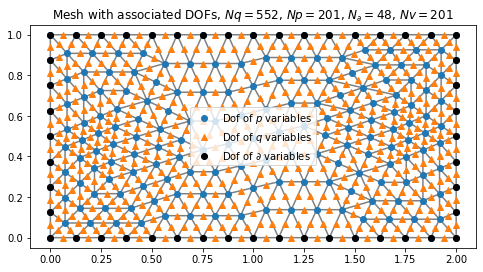

In [25]:
W.notebook = True
W.Plot_Mesh_with_DOFs()    

We plot the Hamiltonian function versus time. 

/home/andrea/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


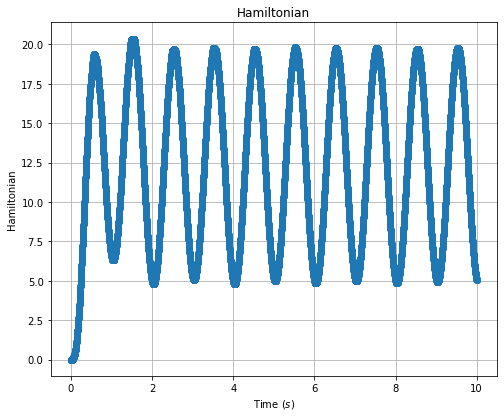

In [26]:
W.Plot_Hamiltonian(W.tspan,Hamiltonian, marker='o')

The behaviour of the deflection can be graphically represented at a given time. Here we simply plot the deflection at the final time. 

/home/andrea/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


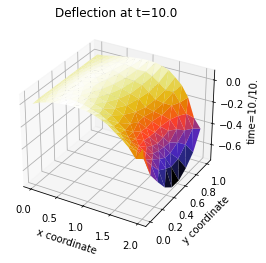

In [27]:
W.Plot_3D(W.Get_Deflection(A), tf, 'Deflection at t='+str(tf))

Furthermore the time evolution of the deflection can be obtained as an animation that can be saved as a movie file. 

In [28]:
movie = True
if movie:
    %matplotlib tk
    W.Set_Video_Writer()
    W.Moving_Trisurf(W.Get_Deflection(A), step=50, title='Deflection versus time', save=False)
    %matplotlib inline

/home/andrea/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Further information

- <a href="https://www.sciencedirect.com/science/article/pii/S2405896318303252">"Structure-preserving Partitioned Finite Element Method for the 2D wave equation"</a> by F. L. Cardoso-Ribeiro, D. Matignon, L. Lefèvre. In IFAC-PapersOnLine, 51 (3), 119–124, 2018.


- <a href="https://dl.acm.org/doi/10.1145/1089014.1089020">"SUNDIALS: Suite of nonlinear and differential/algebraic equation solvers"</a> by A. Hindmarsh and P. Brown, and K. Grant and S. Lee and R. Serban and D. Shumaker and C. Woodward, ACM Transactions on Mathematical Software (TOMS), 31 (3), 363-396, 2005.


- <a href="https://www.sciencedirect.com/science/article/pii/S2405896319303374">"Partitioned Finite Element Method for port-Hamiltonian systems with boundary damping: anisotropic heterogeneous 2D wave equation"</a> by A. Serhani, D. Matignon and G. Haine, IFAC-PapersOnLine, 52 (2), 96-101, 2019. 
